This script reads in the data from Boulder AIR (isoprene, meteorology, ozone, particulate matter), NIDIS (drought data), TESViS MODIS satellite (vegetation related data), and Open-Meteo (meteorological data). Aggregates auto-lagged isoprene, combines the data on time, and saves it to a file for export.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def bair_data_read_in(site_dir:str):
    '''
    reads in the bair data for different data sets

        Args:
            site_dir (str): the directory of the site (LUR)
        
        Returns: 
            df: a dataframe of with timeseries data, the time column is in datetime format and rounded to the nearest minute, nessiary veriables are also selected with the others removed. 

    '''
    df_lst = []
    for file in os.listdir(site_dir):
        try:
            df = pd.read_csv(rf'{site_dir}/{file}', header=1)
            df['time'] = pd.to_datetime(df['time'], unit='s')
            df['time'] = df['time'].dt.round('min')
            df_lst.append(df)
        except:
            pass
    data = pd.concat(df_lst)
    data = data.sort_values('time')
    try:
        data = data.rename(columns={'wsp_avg_ms': 'wsp', 'wdr_avg': 'wdr'})
    except AttributeError:
        pass
    if 'met' in site_dir:
        data = data[['time', 'wsp', 'wdr', 'temp_f', 'nox', 'solr', 'relh']]
    elif 'ozone' in site_dir:
        data = data[['time', 'o3']]
    elif 'pm' in site_dir:
        data = data[['time', 'pm2_5', 'pm10']]
    else:
        data = data[['time', 'isoprene']]
    return data

In [3]:
isoprene = bair_data_read_in(r'/Users/gabegreenberg/Boulder_AIR/BoulderAIR_data/LUR/voc')
isoprene['time'] = isoprene['time'].dt.round('H')
print(isoprene)

                    time  isoprene
0    2020-02-01 01:00:00   0.01731
1    2020-02-01 02:00:00   0.01313
2    2020-02-01 04:00:00   0.01731
3    2020-02-01 05:00:00   0.01851
4    2020-02-01 06:00:00   0.01373
...                  ...       ...
1023 2025-02-19 00:00:00   0.00504
1024 2025-02-19 01:00:00   0.00504
1025 2025-02-19 02:00:00   0.00504
1026 2025-02-19 03:00:00   0.00504
1027 2025-02-19 04:00:00   0.00504

[40055 rows x 2 columns]


/var/folders/2c/kht9wb5n56xdj4mxjj2k7twr0000gn/T/ipykernel_44070/651136489.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  isoprene['time'] = isoprene['time'].dt.round('H')


In [4]:
def isoprene_auto_correlations_func(df, time_col: str):
    '''
        Creates auto-lagged isoprene features (24h, 1W, and 51W)

        Args:
            df: isoprene df for aggrigating
            time_col: (str) the name of the time column
        Returns:
            df: The df with auto-lagged isoprene features
            
    '''
    df = df.copy()

    df[time_col] = pd.to_datetime(df[time_col])
    df = df.sort_values(by=time_col)
    df.set_index(time_col, inplace=True)

    df['week_avg'] = df['isoprene'].resample('W').transform('mean')

    df['previous_week_avg'] = df['week_avg'].shift(freq=pd.DateOffset(days=7))
    df['51_week_avg'] = df['week_avg'].shift(freq=pd.DateOffset(weeks=51))

    df['24_hour_isoprene'] = df['isoprene'].shift(freq='24H') 

    df.fillna(method='ffill', inplace=True)

    df.reset_index(inplace=True)

    return df

In [5]:
#computing the auto-lags
isoprene = isoprene_auto_correlations_func(isoprene, 'time')

/var/folders/2c/kht9wb5n56xdj4mxjj2k7twr0000gn/T/ipykernel_44070/3296776151.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['24_hour_isoprene'] = df['isoprene'].shift(freq='24H')
/var/folders/2c/kht9wb5n56xdj4mxjj2k7twr0000gn/T/ipykernel_44070/3296776151.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [6]:
met = bair_data_read_in(r'/Users/gabegreenberg/Boulder_AIR/BoulderAIR_data/LUR/met')
print(met)


                      time    wsp    wdr  temp_f   nox  solr   relh
0      2020-01-03 01:18:00  1.711  211.0  39.961   NaN   0.0  30.66
1      2020-01-03 01:19:00  3.046  224.7  39.952   NaN   0.0  30.61
2      2020-01-03 01:20:00  3.458  226.1  40.091   NaN   0.0  30.00
3      2020-01-03 01:21:00  2.734  196.2  40.172   NaN   0.0  30.38
4      2020-01-03 01:22:00  2.777  211.6  40.075   NaN   0.0  29.87
...                    ...    ...    ...     ...   ...   ...    ...
129332 2025-03-31 23:55:00  1.650  151.5  53.744  8.28  94.0  61.49
129333 2025-03-31 23:56:00  1.693  138.6  53.780  8.34  93.2  62.90
129334 2025-03-31 23:57:00  0.992  122.6  53.762  8.46  94.0  63.63
129335 2025-03-31 23:58:00  0.614   97.0  53.762  8.65  94.8  64.38
129336 2025-03-31 23:59:00  0.705  112.6  53.726  8.88  93.2  63.30

[2703611 rows x 7 columns]


Clean the met data averge the wdr

In [7]:
# this wind averaging logic was taken from my co-worker Dani Caputi at Boulder AIR
def vector_average(df):
    """
    Calculates the vector-averaged wind speed and direction.

    Args:
        df (pd.DataFrame): DataFrame containing 'wdr' (wind direction) and 'wsp' (wind speed).

    Returns:
        pd.Series: Averaged wind speed and direction.
    """
    direction = df['wdr']
    speed = df['wsp']
    
    u = np.cos(np.radians(direction)) * speed
    v = np.sin(np.radians(direction)) * speed
    u_mean, v_mean = np.nanmean(u), np.nanmean(v)
    
    mean_speed = np.hypot(u_mean, v_mean)
    mean_direction = (np.degrees(np.arctan2(v_mean, u_mean)) + 360) % 360
    
    return pd.Series({'wsp': mean_speed, 'wdr': mean_direction})

# compute vector average to a hourly time resolution and shift met data 24 hours back in time before merging (the 24-hour shift is because I am predicting isoprene 24 hours into the future)
met_wdr_avg = met[['time', 'wsp', 'wdr']].set_index('time')
met_wdr_avg = met_wdr_avg.resample('H').apply(vector_average)
met = met.set_index('time')
met = met.resample('H').mean().reset_index()
met = met.reset_index()
met = met[['time', 'temp_f', 'nox', 'solr', 'relh']]
met = pd.merge(met, met_wdr_avg, on='time', how='outer')
met['time'] -= pd.Timedelta(hours=24)

/var/folders/2c/kht9wb5n56xdj4mxjj2k7twr0000gn/T/ipykernel_44070/53481762.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  met_wdr_avg = met_wdr_avg.resample('H').apply(vector_average)
/var/folders/2c/kht9wb5n56xdj4mxjj2k7twr0000gn/T/ipykernel_44070/53481762.py:17: RuntimeWarning: Mean of empty slice
  u_mean, v_mean = np.nanmean(u), np.nanmean(v)
/var/folders/2c/kht9wb5n56xdj4mxjj2k7twr0000gn/T/ipykernel_44070/53481762.py:28: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  met = met.resample('H').mean().reset_index()


In [8]:
# read in ozone data and shift 24 hours back in time before merging
o3 = bair_data_read_in(r'/Users/gabegreenberg/Boulder_AIR/BoulderAIR_data/LUR/ozone')
o3 = o3.set_index('time')
o3 = o3.resample('H').mean().reset_index()
o3['time'] -= pd.Timedelta(hours=24)
print(o3)

                     time         o3
0     2019-12-12 21:00:00  47.429091
1     2019-12-12 22:00:00  45.884000
2     2019-12-12 23:00:00  41.421667
3     2019-12-13 00:00:00  37.598269
4     2019-12-13 01:00:00  36.180500
...                   ...        ...
46924 2025-04-20 01:00:00  49.062167
46925 2025-04-20 02:00:00  46.372667
46926 2025-04-20 03:00:00  43.060000
46927 2025-04-20 04:00:00  37.116000
46928 2025-04-20 05:00:00  32.476000

[46929 rows x 2 columns]


/var/folders/2c/kht9wb5n56xdj4mxjj2k7twr0000gn/T/ipykernel_44070/2309784084.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  o3 = o3.resample('H').mean().reset_index()


Clean average o3 data

In [9]:
# read in particulate matter data and shift 24 hours back in time before merging
pm = bair_data_read_in(r'/Users/gabegreenberg/Boulder_AIR/BoulderAIR_data/LUR/pm')
pm = pm.set_index('time')
pm = pm.resample('H').mean().reset_index()
pm['time'] -= pd.Timedelta(hours=24)
print(pm)

                     time     pm2_5      pm10
0     2020-01-17 02:00:00  1.794872  9.405128
1     2020-01-17 03:00:00  1.343333  7.445000
2     2020-01-17 04:00:00  1.445000  8.188333
3     2020-01-17 05:00:00  0.780000  1.781667
4     2020-01-17 06:00:00  0.773333  2.175000
...                   ...       ...       ...
45431 2025-03-24 01:00:00  0.655000  1.476667
45432 2025-03-24 02:00:00  1.066667  3.803333
45433 2025-03-24 03:00:00  1.621667  4.260000
45434 2025-03-24 04:00:00  1.105000  3.753333
45435 2025-03-24 05:00:00  1.080000  4.460000

[45436 rows x 3 columns]


/var/folders/2c/kht9wb5n56xdj4mxjj2k7twr0000gn/T/ipykernel_44070/93526511.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pm = pm.resample('H').mean().reset_index()


In [10]:
# combing the boulder air data into a single data set
data = pd.merge(isoprene, met, on='time', how='outer')
data = pd.merge(data, o3, on='time', how='outer')
data = pd.merge(data, pm, on='time', how='outer')

In [11]:
# reading in the drought data and combining into simplified features
drought = pd.read_csv(r'/Users/gabegreenberg/Documents/UW/ds_785_capstone/data/USDM-08013.csv')
drought['no_drought'] = drought['None']
drought['drought_total'] = drought['D0'] + drought['D1'] + drought['D2'] + drought['D3'] + drought['D4']
drought['time'] = drought['ValidStart']
drought = drought[['time', 'no_drought', 'drought_total']]
drought['time'] = pd.to_datetime(drought['time'])
print(drought)

           time  no_drought  drought_total
0    2025-03-18       63.54          39.48
1    2025-03-11       63.54          39.48
2    2025-03-04       63.23          39.79
3    2025-02-25       63.23          39.79
4    2025-02-18       61.18          41.84
...         ...         ...            ...
1311 2000-02-01      100.00           0.00
1312 2000-01-25       73.31          26.69
1313 2000-01-18       73.31          26.69
1314 2000-01-11      100.00           0.00
1315 2000-01-04      100.00           0.00

[1316 rows x 3 columns]


In [12]:
# combing the drough data with the boulder air data because drough data is at a weekly (not hourly) time resolution no time shift is applied and imputation is used
data = pd.merge(data, drought, on='time', how='outer')
data[['no_drought', 'drought_total']] = data[['no_drought', 'drought_total']].fillna(method='ffill')

/var/folders/2c/kht9wb5n56xdj4mxjj2k7twr0000gn/T/ipykernel_44070/3196092777.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[['no_drought', 'drought_total']] = data[['no_drought', 'drought_total']].fillna(method='ffill')


In [13]:
def read_in_MODIS_data(dir:str, mesurment:str):
    '''
    Read in the modis data remove data from (grid cells with erros), average into a single value lai, fpar return the df with the averaged values.

    Arg:
        dir (str): directory of the modis satallight data (lai or fpar)
        mesurment (str): lai or fpar
    
    Returns:
        df: the averaged modis dataframe 
    '''
    df = pd.read_csv(fr'{dir}')
    # (F values signify an error in the data)
    df.replace("F", np.nan, inplace=True)
    df = df.iloc[:, [2]].join(df.iloc[:, 5:])
    df = df.set_index(df.columns[0])
    df = df.apply(pd.to_numeric)
    # take the average of all grid cells to get a lai, fpar estimate since the data is nearby but not covering the LUR monitoing station
    df = df.mean(axis=1)
    df = df.reset_index()
    df.columns = ['time', mesurment]
    df['time'] = df['time'].str[1:]

    def convert_to_datetime(time):
        year = int(str(time)[:4])  
        day_of_year = int(str(time)[4:])  
        return pd.Timestamp(year=year, month=1, day=1) + pd.Timedelta(days=day_of_year - 1)
    
    df['time'] = df['time'].apply(convert_to_datetime)
    df['time'] = pd.to_datetime(df['time'])
    
    return df

modis_mlai = read_in_MODIS_data('/Users/gabegreenberg/Documents/UW/ds_785_capstone/data/filtered_scaled_Lai_500m (2).csv', 'mlai')
modis_fpar = read_in_MODIS_data('/Users/gabegreenberg/Documents/UW/ds_785_capstone/data/filtered_scaled_Fpar_500m.csv', 'mfpar')
modis = pd.merge(modis_mlai, modis_fpar, on='time', how='outer')
print(modis)

/var/folders/2c/kht9wb5n56xdj4mxjj2k7twr0000gn/T/ipykernel_44070/2014201973.py:12: DtypeWarning: Columns (7,8,9,10,22,23,24,25,63,64,79,80,81,82,83,255,256,257,258,259,268,270,271,272,273,274,275,276,283,284,285,286,289,290,291,292,293) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fr'{dir}')
/var/folders/2c/kht9wb5n56xdj4mxjj2k7twr0000gn/T/ipykernel_44070/2014201973.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace("F", np.nan, inplace=True)
/var/folders/2c/kht9wb5n56xdj4mxjj2k7twr0000gn/T/ipykernel_44070/2014201973.py:12: DtypeWarning: Columns (7,8,9,10,22,23,24,25,63,64,79,80,81,82,83,255,256,257,258,259,268,270,271,272,273,274,275,276,283,284,285,286,289,290,291,292,293) have mixed types. Speci

           time      mlai     mfpar
0    2002-07-08  0.828571  0.373496
1    2002-07-12  0.841729  0.379098
2    2002-07-16  0.825564  0.371729
3    2002-07-20  0.749248  0.341241
4    2002-07-24  0.755639  0.355977
...         ...       ...       ...
2055 2024-12-18  0.241353  0.194662
2056 2024-12-22  0.223684  0.182481
2057 2024-12-26  0.207500  0.172500
2058 2024-12-30  0.234211  0.196053
2059 2025-01-01  0.205660  0.171623

[2060 rows x 3 columns]


/var/folders/2c/kht9wb5n56xdj4mxjj2k7twr0000gn/T/ipykernel_44070/2014201973.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace("F", np.nan, inplace=True)


In [14]:
# merge with bair data because the time resultion is on the order of days not hours no timeshift gets applied
data = pd.merge(data, modis, on='time', how='outer')
data[['mlai', 'mfpar']] = data[['mlai', 'mfpar']].fillna(method='ffill')

/var/folders/2c/kht9wb5n56xdj4mxjj2k7twr0000gn/T/ipykernel_44070/2285368699.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[['mlai', 'mfpar']] = data[['mlai', 'mfpar']].fillna(method='ffill')


In [15]:
# read in the open meto-data and shift 24 hours back in time before merging with the rest of the data
open_meto = pd.read_csv(r'/Users/gabegreenberg/Documents/UW/ds_785_capstone/data/open-meteo-40.18N105.03W1513_v2m.csv', header=2)
open_meto['time'] = pd.to_datetime(open_meto['time'])
open_meto = open_meto[['time', 'precipitation (mm)', 'cloud_cover (%)', 'surface_pressure (hPa)']]
open_meto['time'] -= pd.Timedelta(hours=24)
print(open_meto)

                     time  precipitation (mm)  cloud_cover (%)  \
0     2020-01-01 00:00:00                 0.0                1   
1     2020-01-01 01:00:00                 0.0                5   
2     2020-01-01 02:00:00                 0.0                1   
3     2020-01-01 03:00:00                 0.0                2   
4     2020-01-01 04:00:00                 0.0                3   
...                   ...                 ...              ...   
45283 2025-03-01 19:00:00                 0.0                3   
45284 2025-03-01 20:00:00                 0.0                0   
45285 2025-03-01 21:00:00                 0.0                0   
45286 2025-03-01 22:00:00                 0.0                0   
45287 2025-03-01 23:00:00                 0.0                0   

       surface_pressure (hPa)  
0                       832.5  
1                       831.4  
2                       830.0  
3                       829.0  
4                       828.7  
...            

In [16]:
# merge open_meto data with the rest of the dataset
data = pd.merge(data, open_meto, on='time', how='outer')

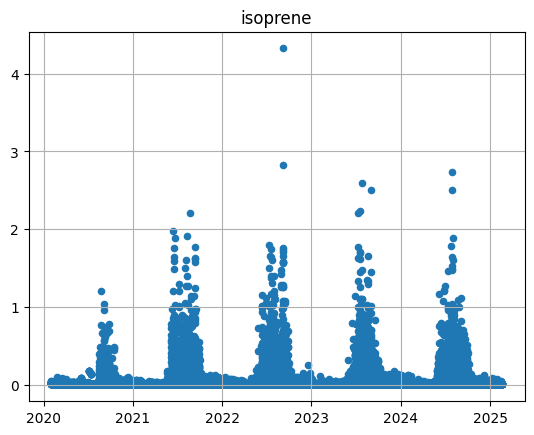

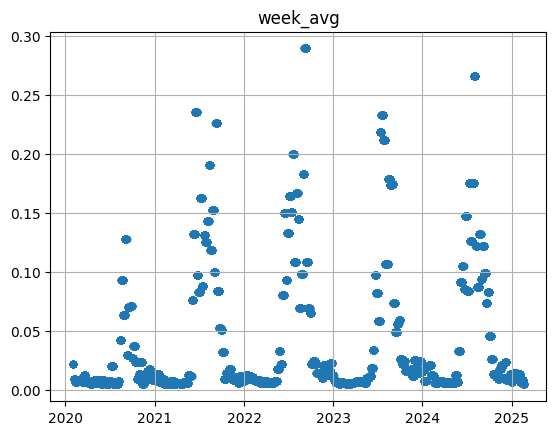

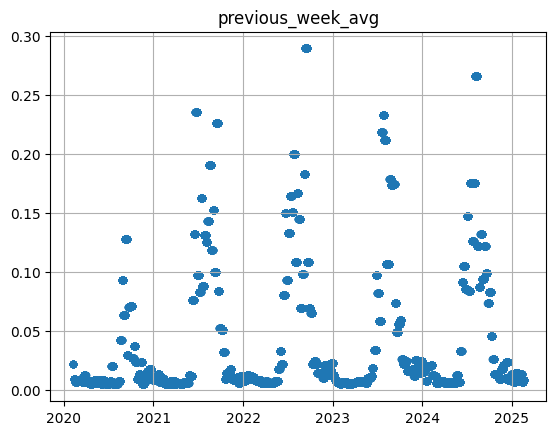

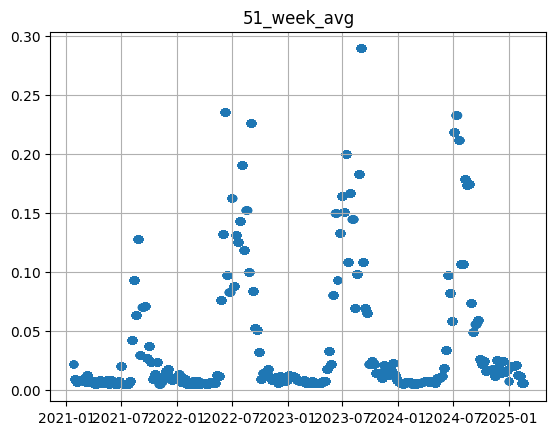

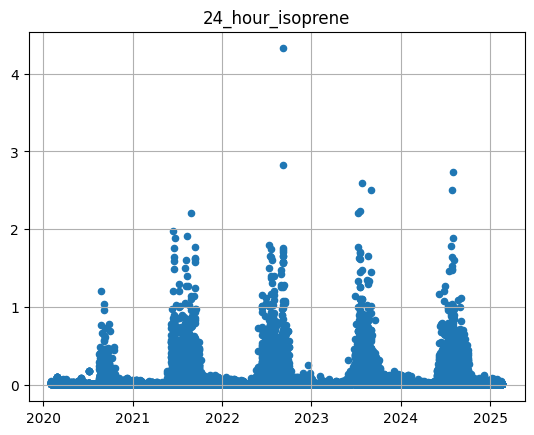

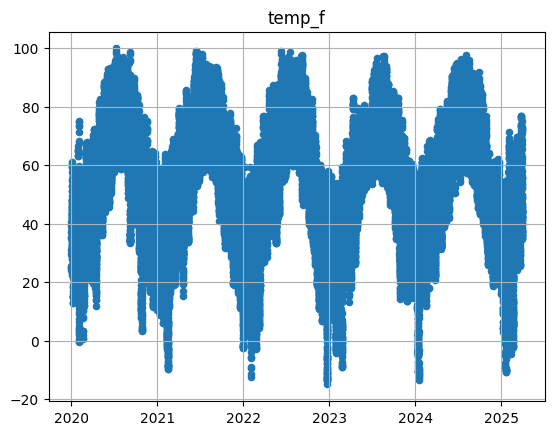

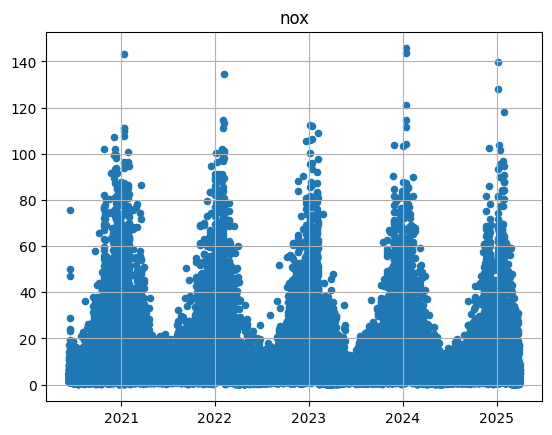

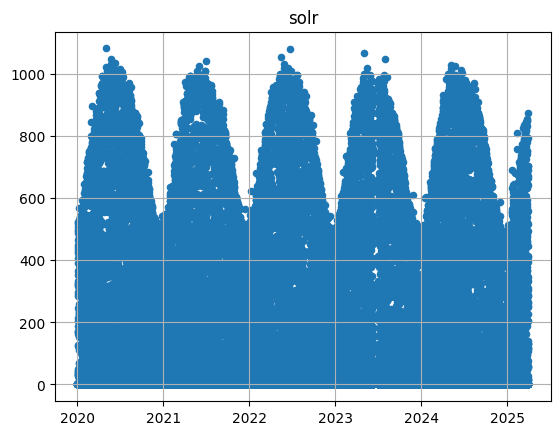

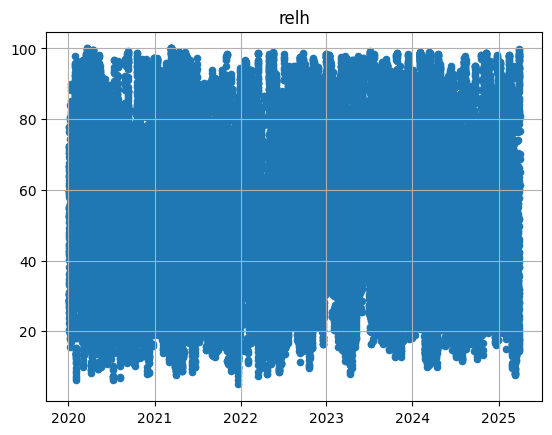

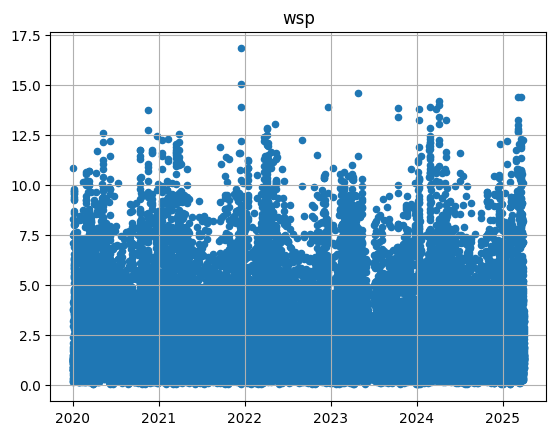

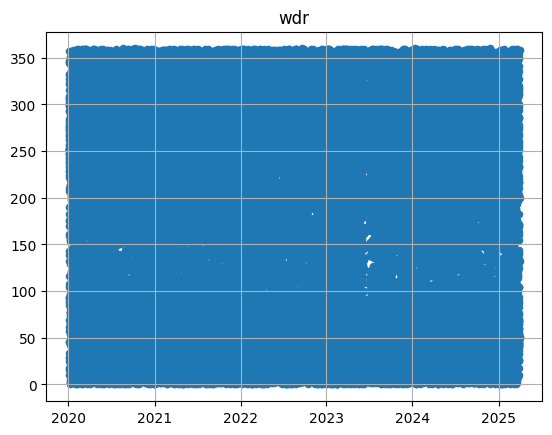

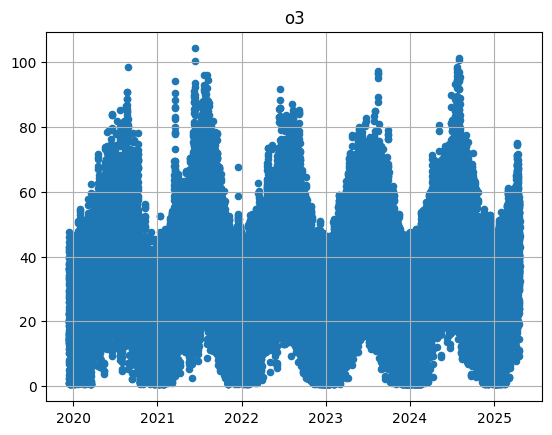

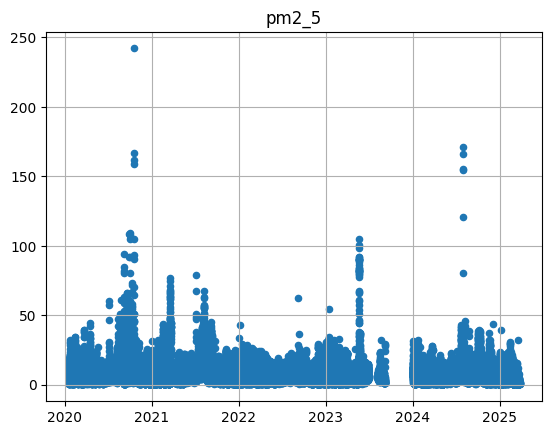

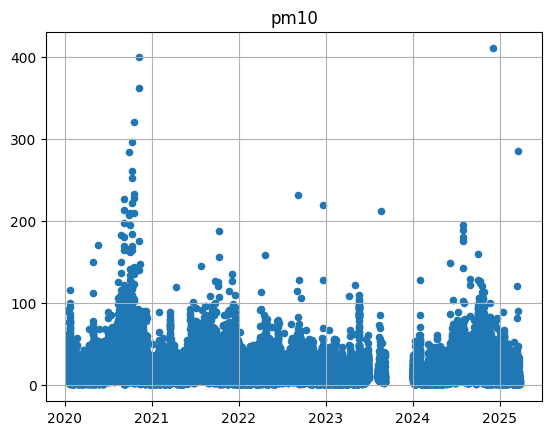

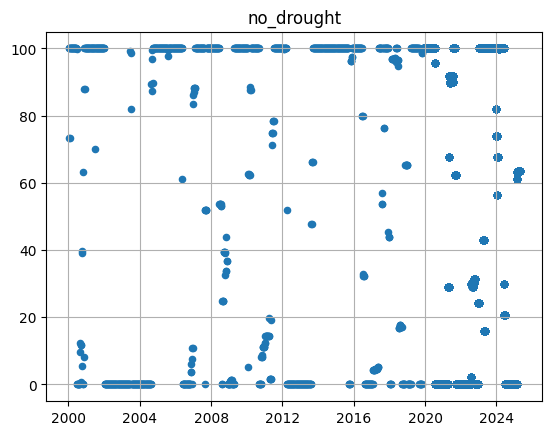

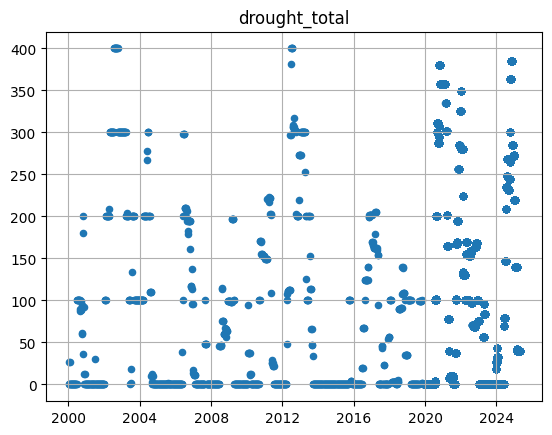

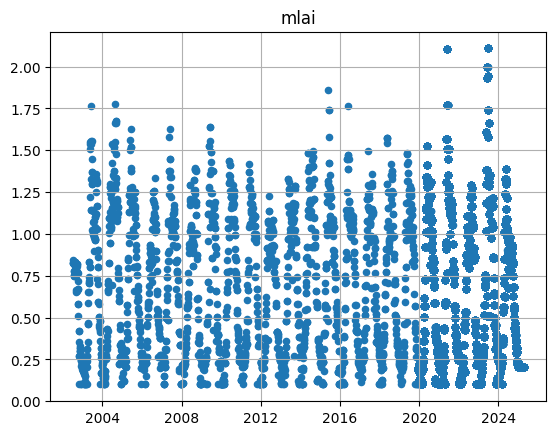

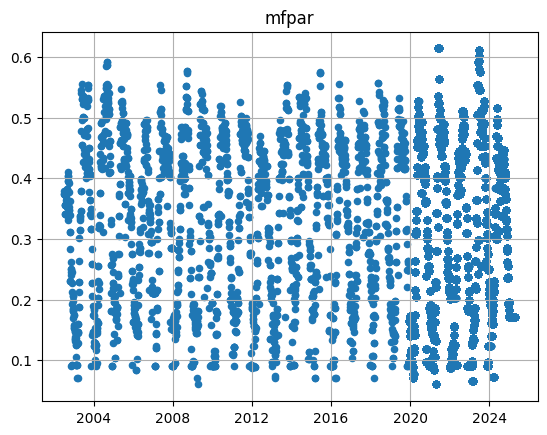

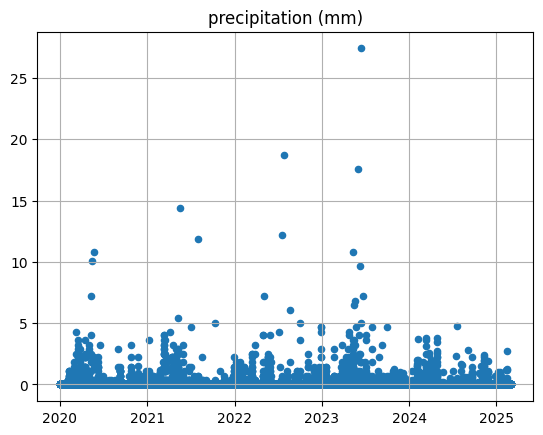

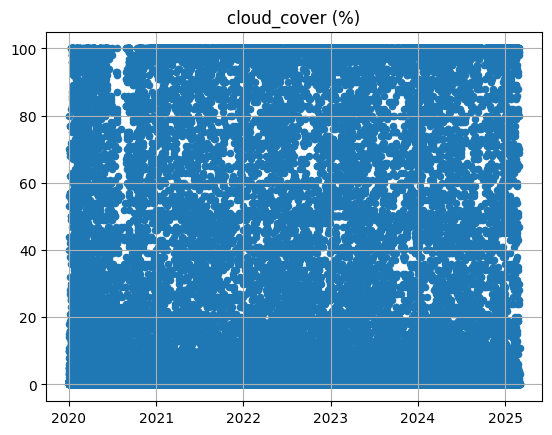

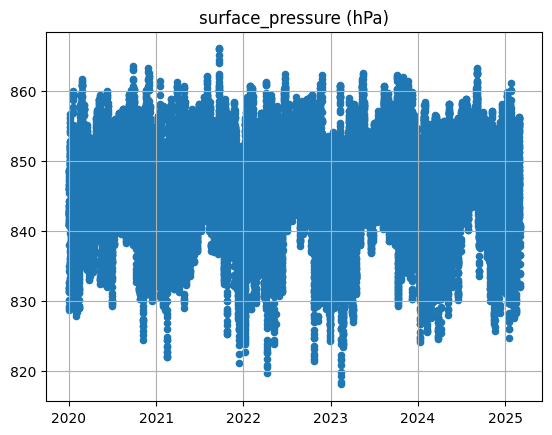

In [17]:
for col in data.columns:
    if col != 'time':
        plt.scatter(data['time'], data[col], s=20)
        plt.title(f'{col}')
        plt.grid()
        plt.show()

In [ ]:
data = data.loc[data['time'] <= '2024-12-31']
data = data.drop(columns=['week_avg'])
data = data.dropna()
print(data)

#exporting the combined data for use with my other scripts
data.to_csv(fr'/Users/gabegreenberg/Documents/UW/ds_785_capstone/data/historical_data.csv', index=False)


                     time  isoprene  previous_week_avg  51_week_avg  \
12183 2021-01-23 01:00:00  0.004636           0.013394     0.022043   
12184 2021-01-23 02:00:00  0.004636           0.013394     0.022043   
12185 2021-01-23 03:00:00  0.004636           0.013394     0.022043   
12186 2021-01-23 04:00:00  0.004636           0.013394     0.022043   
12187 2021-01-23 05:00:00  0.004636           0.013394     0.022043   
...                   ...       ...                ...          ...   
46690 2024-12-30 20:00:00  0.005008           0.013522     0.007293   
46691 2024-12-30 21:00:00  0.005008           0.013522     0.007293   
46692 2024-12-30 22:00:00  0.005008           0.013522     0.007293   
46693 2024-12-30 23:00:00  0.005008           0.013522     0.007293   
46694 2024-12-31 00:00:00  0.005008           0.013522     0.007293   

       24_hour_isoprene     temp_f       nox        solr       relh       wsp  \
12183          0.004636  29.215617  3.406550    0.000000  72.63150